# Coursework: Object Detection - Maciej Legas - 2031545
## Imports
Import the necessary packages for this coursework.

In [32]:
from timeit import default_timer as timer
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.feature
import seaborn as sns
# The package above is used for confusion matrix visualization. Reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle

## Data

### Loading, reshaping and shuffling data

In [33]:
# The following variable is used in confusion matrices for axis labeling. 
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

In [34]:
train_data = np.load('trnImage.npy')
train_labels = np.load('trnLabel.npy')
test_data = np.load('tstImage.npy')
test_labels = np.load('tstLabel.npy')

In [35]:
# Change the shape from Width x Height x Channels x Samples to Samples x Width x Height x Channels.
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data, (3, 0, 1, 2))

In [36]:
print(train_data.shape)
print(test_data.shape)

(10000, 32, 32, 3)
(1000, 32, 32, 3)


In [37]:
# As the data is sorted in order, we need to shuffle it for training.
train_data, train_labels = shuffle(train_data, train_labels)
test_data, test_labels = shuffle(test_data, test_labels)

In [9]:
# Reshapes the data for use in LDA, SVM and fully connected neural networks.
reshaped_train_data = train_data.reshape(10000, 3072)
reshaped_test_data = test_data.reshape(1000, 3072)

### Histogram of Oriented Gradients

In [10]:
hog_train_data = np.zeros((10000, 324))

for i in range(0, 10000):
  hog_train_data[i, :] = skimage.feature.hog(train_data[i,:,:,:], visualize=False, block_norm='L2-Hys')

In [11]:
hog_test_data = np.zeros((1000, 324))

for i in range(0, 1000):
  hog_test_data[i, :] = skimage.feature.hog(test_data[i,:,:,:], visualize=False, block_norm='L2-Hys')

### Linear Discriminant Analysis (on raw and HOG data)

In [12]:
lda = LinearDiscriminantAnalysis().fit(reshaped_train_data, np.ravel(train_labels))

In [13]:
lda_train_data = lda.transform(reshaped_train_data)
lda_test_data = lda.transform(reshaped_test_data)

print(lda_train_data.shape)

(10000, 9)


In [14]:
hog_lda = LinearDiscriminantAnalysis().fit(hog_train_data, np.ravel(train_labels))

In [15]:
hog_lda_train_data = hog_lda.transform(hog_train_data)
hog_lda_test_data = hog_lda.transform(hog_test_data)

print(hog_lda_train_data.shape)

(10000, 9)


## SVM

### Using the dataset directly as input

In [16]:
standard_scaler = StandardScaler().fit(reshaped_train_data)

In [17]:
svm_train_data = standard_scaler.transform(reshaped_train_data)
svm_test_data = standard_scaler.transform(reshaped_test_data)

In [18]:
start = timer()
svm = SVC(kernel='rbf', C=1.0).fit(svm_train_data, np.ravel(train_labels))
end = timer()

In [19]:
time_taken = end - start
print(time_taken, "seconds training time.")

476.08349776800003 seconds training time.


In [20]:
svm.score(svm_test_data, test_labels)

0.484

[[53  5  4  4  3  2  4  3 18  4]
 [ 5 50  3  2  5  1  4  6  7 17]
 [16  1 33  6 16  5 10  6  3  4]
 [ 6  3  9 34 10 17  4  4  4  9]
 [ 2  4 10  8 46  6 11  3  6  4]
 [ 2  3 10 17  6 43  9  2  5  3]
 [ 3  1  8  7 11  4 56  3  2  5]
 [ 5  5  7  5 16  7  4 43  1  7]
 [ 6  9  5  2  1  1  0  1 68  7]
 [ 7 18  0  4  0  4  1  3  5 58]]


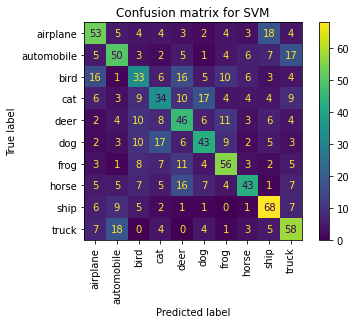

In [21]:
chart = plot_confusion_matrix(svm, svm_test_data, test_labels, xticks_rotation = 'vertical',
                              display_labels=class_labels)
chart.ax_.set_title("Confusion matrix for SVM")
print(chart.confusion_matrix)

In [22]:
predictions = svm.predict(svm_test_data)

In [23]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52       100
           1       0.51      0.50      0.50       100
           2       0.37      0.33      0.35       100
           3       0.38      0.34      0.36       100
           4       0.40      0.46      0.43       100
           5       0.48      0.43      0.45       100
           6       0.54      0.56      0.55       100
           7       0.58      0.43      0.49       100
           8       0.57      0.68      0.62       100
           9       0.49      0.58      0.53       100

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000



### HOG + SVM

In [24]:
standard_scaler = StandardScaler().fit(hog_train_data)

In [25]:
svm_train_data = standard_scaler.transform(hog_train_data)
svm_test_data = standard_scaler.transform(hog_test_data)

In [26]:
start = timer()
svm = SVC(kernel='rbf', C=1.0).fit(svm_train_data, np.ravel(train_labels))
end = timer()

In [27]:
time_taken = end - start
print(time_taken, "seconds training time.")

44.386343501000056 seconds training time.


In [28]:
svm.score(svm_test_data, test_labels)

0.599

[[69  2  6  2  4  1  2  4  9  1]
 [ 4 64  0  2  4  1  3  3 11  8]
 [ 6  1 50  6  6 15  8  4  2  2]
 [ 2  3 14 42 11 11  9  4  1  3]
 [ 4  2  7 13 63  4  5  0  2  0]
 [ 1  1  6  9  9 58  7  7  1  1]
 [ 2  4  7  7  8  8 62  1  1  0]
 [ 2  0  6 10 11  8  3 56  1  3]
 [10 10  4  2  1  0  1  0 69  3]
 [ 5  7  2  4  2  3  0  2  9 66]]


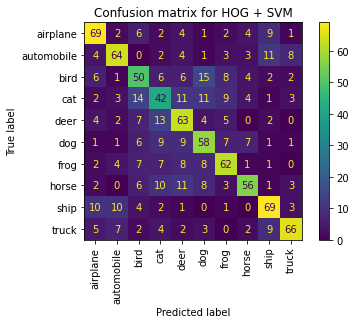

In [29]:
chart = plot_confusion_matrix(svm, svm_test_data, test_labels, xticks_rotation = 'vertical',
                              display_labels=class_labels)
chart.ax_.set_title("Confusion matrix for HOG + SVM")
print(chart.confusion_matrix)

In [30]:
predictions = svm.predict(svm_test_data)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       100
           1       0.68      0.64      0.66       100
           2       0.49      0.50      0.50       100
           3       0.43      0.42      0.43       100
           4       0.53      0.63      0.58       100
           5       0.53      0.58      0.56       100
           6       0.62      0.62      0.62       100
           7       0.69      0.56      0.62       100
           8       0.65      0.69      0.67       100
           9       0.76      0.66      0.71       100

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



### LDA + SVM

In [ ]:
standard_scaler = StandardScaler().fit(lda_train_data)

In [ ]:
svm_train_data = standard_scaler.transform(lda_train_data)
svm_test_data = standard_scaler.transform(lda_test_data)

In [ ]:
start = timer()
svm = SVC(kernel='rbf', C=1.0).fit(svm_train_data, np.ravel(train_labels))
end = timer()

In [ ]:
time_taken = end - start
print(time_taken, "seconds training time.")

1.8940473450002173 seconds training time.


In [ ]:
svm.score(svm_test_data, test_labels)

0.252

[[28 16  6  4  6  2  4  4 21  9]
 [ 6 41  7  5  4  8  4  9  3 13]
 [13 12 13 10  8 10 10 14  6  4]
 [ 9  7 10 22 11 17  8  7  4  5]
 [ 5  9 10 10 25  9 12 10  7  3]
 [ 2 13  5 14 12 22 16  2  9  5]
 [ 3 11 12 18 10 14 17  5  4  6]
 [ 4 10 14  8 11 11 10 20  5  7]
 [15  9  6  3  3  6  4  3 37 14]
 [ 7 26  8  6  6  2  2  5 11 27]]


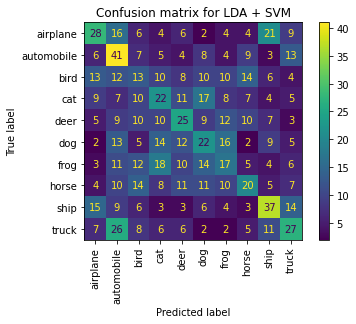

In [ ]:
chart = plot_confusion_matrix(svm, svm_test_data, test_labels, xticks_rotation = 'vertical',
                                 display_labels=class_labels)
chart.ax_.set_title("Confusion matrix for LDA + SVM")
print(chart.confusion_matrix)

In [ ]:
predictions = svm.predict(svm_test_data)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       100
           1       0.27      0.41      0.32       100
           2       0.14      0.13      0.14       100
           3       0.22      0.22      0.22       100
           4       0.26      0.25      0.26       100
           5       0.22      0.22      0.22       100
           6       0.20      0.17      0.18       100
           7       0.25      0.20      0.22       100
           8       0.35      0.37      0.36       100
           9       0.29      0.27      0.28       100

    accuracy                           0.25      1000
   macro avg       0.25      0.25      0.25      1000
weighted avg       0.25      0.25      0.25      1000



### HOG + LDA + SVM

In [ ]:
standard_scaler = StandardScaler().fit(hog_lda_train_data)

In [ ]:
svm_train_data = standard_scaler.transform(hog_lda_train_data)
svm_test_data = standard_scaler.transform(hog_lda_test_data)

In [ ]:
start = timer()
svm = SVC(kernel='rbf', C=1.0).fit(svm_train_data, np.ravel(train_labels))
end = timer()

In [ ]:
time_taken = end - start
print(time_taken, "seconds training time.")

3.9660458629996356 seconds training time.


In [ ]:
svm.score(svm_test_data, test_labels)

0.501

[[64  3  7  1  6  1  3  2  9  4]
 [ 5 51  2  4  5  1  4  3 12 13]
 [ 9  4 37  6  8 18 10  4  4  0]
 [ 3  5 13 27 17 11 14  6  2  2]
 [ 5  2 10 11 53  5  8  4  0  2]
 [ 2  3  9 10  9 53  7  6  0  1]
 [ 1  3  9  9 11  8 50  7  0  2]
 [ 0  2  4 10 16  5  3 52  3  5]
 [17 11  4  3  3  0  1  0 53  8]
 [ 4 10  2  1  4  2  2  3 11 61]]


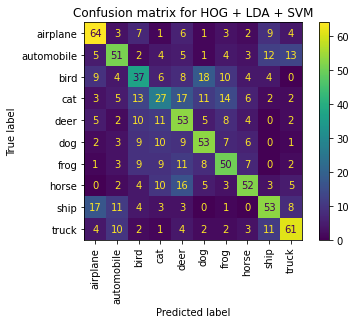

In [ ]:
chart = plot_confusion_matrix(svm, svm_test_data, test_labels, xticks_rotation = 'vertical',
                                 display_labels=class_labels)
chart.ax_.set_title("Confusion matrix for HOG + LDA + SVM")
print(chart.confusion_matrix)

In [ ]:
predictions = svm.predict(svm_test_data)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       100
           1       0.54      0.51      0.53       100
           2       0.38      0.37      0.38       100
           3       0.33      0.27      0.30       100
           4       0.40      0.53      0.46       100
           5       0.51      0.53      0.52       100
           6       0.49      0.50      0.50       100
           7       0.60      0.52      0.56       100
           8       0.56      0.53      0.55       100
           9       0.62      0.61      0.62       100

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



## Artificial Neural Network

### Using the dataset directly as input

In [ ]:
nn_model = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(3072, activation=tf.nn.relu),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [ ]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
start = timer()
nn_log = nn_model.fit(reshaped_train_data, train_labels, epochs=100, validation_split=0.1, verbose=1)
end = timer()

Epoch 1/100
282/282 [==============================] - 3s 9ms/step - loss: 2.1857 - sparse_categorical_accuracy: 0.2118 - val_loss: 1.9137 - val_sparse_categorical_accuracy: 0.3030
Epoch 2/100
282/282 [==============================] - 2s 8ms/step - loss: 1.8921 - sparse_categorical_accuracy: 0.3097 - val_loss: 1.9445 - val_sparse_categorical_accuracy: 0.2970
Epoch 3/100
282/282 [==============================] - 2s 8ms/step - loss: 1.8301 - sparse_categorical_accuracy: 0.3308 - val_loss: 1.8544 - val_sparse_categorical_accuracy: 0.3210
Epoch 4/100
282/282 [==============================] - 2s 8ms/step - loss: 1.7566 - sparse_categorical_accuracy: 0.3582 - val_loss: 1.8529 - val_sparse_categorical_accuracy: 0.3390
Epoch 5/100
282/282 [==============================] - 2s 8ms/step - loss: 1.7108 - sparse_categorical_accuracy: 0.3789 - val_loss: 1.7821 - val_sparse_categorical_accuracy: 0.3560
Epoch 6/100
282/282 [==============================] - 2s 8ms/step - loss: 1.6599 - sparse_cate

In [ ]:
time_taken = end - start
print(time_taken, "seconds training time.")

237.72181586100032 seconds training time.


In [ ]:
nn_model.evaluate(reshaped_test_data, test_labels)

32/32 [==============================] - 0s 3ms/step - loss: 6.1901 - sparse_categorical_accuracy: 0.4150


[6.190061092376709, 0.41499999165534973]

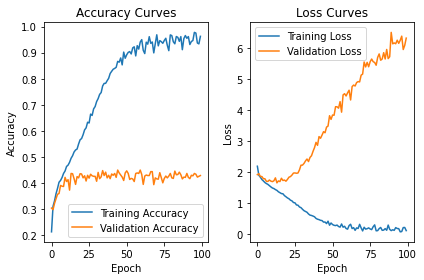

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(nn_log.history['sparse_categorical_accuracy'])
plt.plot(nn_log.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(nn_log.history['loss'])
plt.plot(nn_log.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')

plt.tight_layout()
plt.show()

In [ ]:
predictions = np.argmax(nn_model.predict(reshaped_test_data), axis=-1)

In [ ]:
cm = confusion_matrix(test_labels, predictions)

Confusion matrix for MLP NN


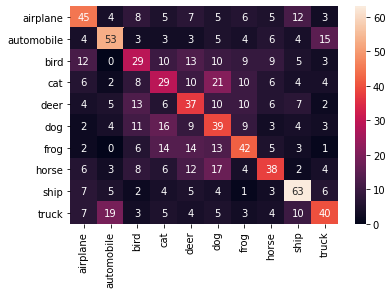

In [ ]:
print("Confusion matrix for MLP NN")
sns.heatmap(cm, annot=True, xticklabels=class_labels, 
            yticklabels=class_labels)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.47      0.45      0.46       100
           1       0.56      0.53      0.54       100
           2       0.32      0.29      0.30       100
           3       0.30      0.29      0.29       100
           4       0.32      0.37      0.35       100
           5       0.30      0.39      0.34       100
           6       0.43      0.42      0.42       100
           7       0.45      0.38      0.41       100
           8       0.55      0.63      0.59       100
           9       0.49      0.40      0.44       100

    accuracy                           0.41      1000
   macro avg       0.42      0.42      0.42      1000
weighted avg       0.42      0.41      0.42      1000



### HOG + Neural Network

In [ ]:
nn_hog_model = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(324, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [ ]:
nn_hog_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
start = timer()
nn_hog_log = nn_hog_model.fit(hog_train_data, train_labels, epochs=100, validation_split=0.1, verbose=1)
end = timer()

Epoch 1/100
282/282 [==============================] - 1s 4ms/step - loss: 2.0312 - sparse_categorical_accuracy: 0.2454 - val_loss: 1.7714 - val_sparse_categorical_accuracy: 0.3680
Epoch 2/100
282/282 [==============================] - 1s 3ms/step - loss: 1.7685 - sparse_categorical_accuracy: 0.3604 - val_loss: 1.6197 - val_sparse_categorical_accuracy: 0.4410
Epoch 3/100
282/282 [==============================] - 1s 3ms/step - loss: 1.6646 - sparse_categorical_accuracy: 0.4061 - val_loss: 1.5353 - val_sparse_categorical_accuracy: 0.4790
Epoch 4/100
282/282 [==============================] - 1s 3ms/step - loss: 1.5806 - sparse_categorical_accuracy: 0.4388 - val_loss: 1.5056 - val_sparse_categorical_accuracy: 0.4920
Epoch 5/100
282/282 [==============================] - 1s 3ms/step - loss: 1.5111 - sparse_categorical_accuracy: 0.4713 - val_loss: 1.4539 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/100
282/282 [==============================] - 1s 3ms/step - loss: 1.4585 - sparse_cate

In [ ]:
time_taken = end - start
print(time_taken, "seconds training time.")

96.55819325399989 seconds training time.


In [ ]:
nn_hog_model.evaluate(hog_test_data, test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 4.9237 - sparse_categorical_accuracy: 0.5250


[4.923712730407715, 0.5249999761581421]

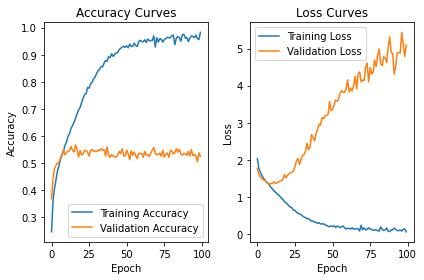

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(nn_hog_log.history['sparse_categorical_accuracy'])
plt.plot(nn_hog_log.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(nn_hog_log.history['loss'])
plt.plot(nn_hog_log.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')

plt.tight_layout()
plt.show()

In [ ]:
predictions = np.argmax(nn_hog_model.predict(hog_test_data), axis=-1)

In [ ]:
cm = confusion_matrix(test_labels, predictions)

Confusion matrix for HOG + MLP NN


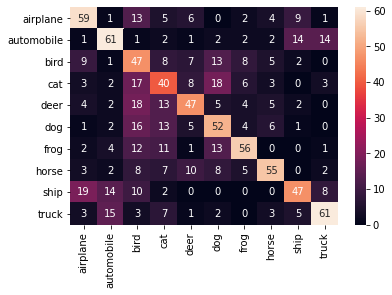

In [ ]:
print("Confusion matrix for HOG + MLP NN")
sns.heatmap(cm, annot=True, xticklabels=class_labels, 
            yticklabels=class_labels)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       100
           1       0.59      0.61      0.60       100
           2       0.32      0.47      0.38       100
           3       0.37      0.40      0.38       100
           4       0.55      0.47      0.51       100
           5       0.46      0.52      0.49       100
           6       0.64      0.56      0.60       100
           7       0.66      0.55      0.60       100
           8       0.59      0.47      0.52       100
           9       0.68      0.61      0.64       100

    accuracy                           0.53      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.54      0.53      0.53      1000



### LDA + Neural Network

In [ ]:
nn_lda_model = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(9, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [ ]:
nn_lda_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
start = timer()
nn_lda_log = nn_lda_model.fit(lda_train_data, train_labels, epochs=100, validation_split=0.1, verbose=1)
end = timer()

Epoch 1/100
282/282 [==============================] - 1s 4ms/step - loss: 2.2810 - sparse_categorical_accuracy: 0.1654 - val_loss: 2.0712 - val_sparse_categorical_accuracy: 0.3080
Epoch 2/100
282/282 [==============================] - 1s 3ms/step - loss: 2.0740 - sparse_categorical_accuracy: 0.2210 - val_loss: 1.8856 - val_sparse_categorical_accuracy: 0.3880
Epoch 3/100
282/282 [==============================] - 1s 3ms/step - loss: 1.9911 - sparse_categorical_accuracy: 0.2402 - val_loss: 1.7477 - val_sparse_categorical_accuracy: 0.5050
Epoch 4/100
282/282 [==============================] - 1s 3ms/step - loss: 1.9175 - sparse_categorical_accuracy: 0.2674 - val_loss: 1.6404 - val_sparse_categorical_accuracy: 0.5510
Epoch 5/100
282/282 [==============================] - 1s 3ms/step - loss: 1.8494 - sparse_categorical_accuracy: 0.2930 - val_loss: 1.5683 - val_sparse_categorical_accuracy: 0.5720
Epoch 6/100
282/282 [==============================] - 1s 3ms/step - loss: 1.8423 - sparse_cate

In [ ]:
time_taken = end - start
print(time_taken, "seconds training time.")

91.48492144100055 seconds training time.


In [ ]:
nn_lda_model.evaluate(lda_test_data, test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 3.0261 - sparse_categorical_accuracy: 0.2450


[3.026127815246582, 0.24500000476837158]

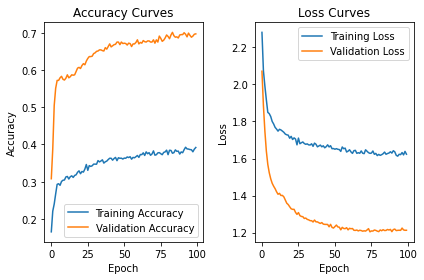

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(nn_lda_log.history['sparse_categorical_accuracy'])
plt.plot(nn_lda_log.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(nn_lda_log.history['loss'])
plt.plot(nn_lda_log.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')

plt.tight_layout()
plt.show()

In [ ]:
predictions = np.argmax(nn_lda_model.predict(lda_test_data), axis=-1)

In [ ]:
cm = confusion_matrix(test_labels, predictions)

Confusion matrix for LDA + MLP NN


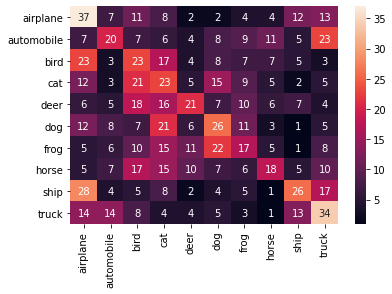

In [ ]:
print("Confusion matrix for LDA + MLP NN")
sns.heatmap(cm, annot=True, xticklabels=class_labels, 
            yticklabels=class_labels)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.25      0.37      0.30       100
           1       0.26      0.20      0.23       100
           2       0.18      0.23      0.20       100
           3       0.17      0.23      0.20       100
           4       0.30      0.21      0.25       100
           5       0.25      0.26      0.25       100
           6       0.21      0.17      0.19       100
           7       0.30      0.18      0.22       100
           8       0.34      0.26      0.29       100
           9       0.28      0.34      0.31       100

    accuracy                           0.24      1000
   macro avg       0.25      0.25      0.24      1000
weighted avg       0.25      0.24      0.24      1000



### HOG + LDA + Neural Network

In [ ]:
nn_hog_lda_model = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(9, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [ ]:
nn_hog_lda_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
start = timer()
nn_hog_lda_log = nn_hog_lda_model.fit(hog_lda_train_data, train_labels, epochs=100, validation_split=0.1, verbose=1)
end = timer()

Epoch 1/100
282/282 [==============================] - 1s 4ms/step - loss: 2.3179 - sparse_categorical_accuracy: 0.1239 - val_loss: 2.2048 - val_sparse_categorical_accuracy: 0.2280
Epoch 2/100
282/282 [==============================] - 1s 3ms/step - loss: 2.2208 - sparse_categorical_accuracy: 0.1810 - val_loss: 2.1443 - val_sparse_categorical_accuracy: 0.2770
Epoch 3/100
282/282 [==============================] - 1s 3ms/step - loss: 2.1981 - sparse_categorical_accuracy: 0.1939 - val_loss: 2.1160 - val_sparse_categorical_accuracy: 0.2900
Epoch 4/100
282/282 [==============================] - 1s 3ms/step - loss: 2.1731 - sparse_categorical_accuracy: 0.2028 - val_loss: 2.0769 - val_sparse_categorical_accuracy: 0.3150
Epoch 5/100
282/282 [==============================] - 1s 3ms/step - loss: 2.1511 - sparse_categorical_accuracy: 0.2079 - val_loss: 2.0464 - val_sparse_categorical_accuracy: 0.3100
Epoch 6/100
282/282 [==============================] - 1s 3ms/step - loss: 2.1247 - sparse_cate

In [ ]:
time_taken = end - start
print(time_taken, "seconds training time.")

91.97552833200007 seconds training time.


In [ ]:
nn_hog_lda_model.evaluate(hog_lda_test_data, test_labels)

32/32 [==============================] - 0s 2ms/step - loss: 1.7390 - sparse_categorical_accuracy: 0.4270


[1.7390260696411133, 0.4269999861717224]

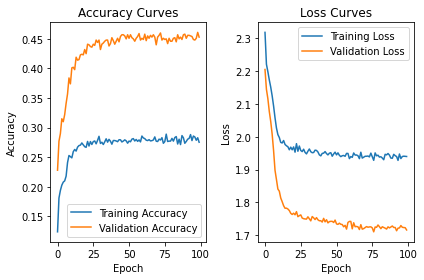

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(nn_hog_lda_log.history['sparse_categorical_accuracy'])
plt.plot(nn_hog_lda_log.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(nn_hog_lda_log.history['loss'])
plt.plot(nn_hog_lda_log.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')

plt.tight_layout()
plt.show()

In [ ]:
predictions = np.argmax(nn_hog_lda_model.predict(hog_lda_test_data), axis=-1)

In [ ]:
cm = confusion_matrix(test_labels, predictions)

Confusion matrix for HOG + LDA + MLP NN


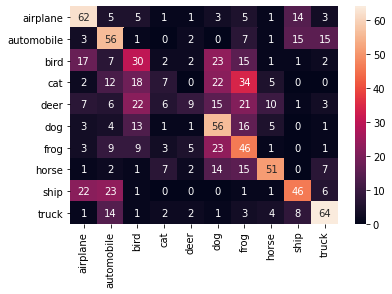

In [ ]:
print("Confusion matrix for HOG + LDA + MLP NN")
sns.heatmap(cm, annot=True, xticklabels=class_labels, 
            yticklabels=class_labels)

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       100
           1       0.41      0.56      0.47       100
           2       0.30      0.30      0.30       100
           3       0.24      0.07      0.11       100
           4       0.38      0.09      0.15       100
           5       0.36      0.56      0.44       100
           6       0.28      0.46      0.35       100
           7       0.64      0.51      0.57       100
           8       0.54      0.46      0.50       100
           9       0.63      0.64      0.63       100

    accuracy                           0.43      1000
   macro avg       0.43      0.43      0.41      1000
weighted avg       0.43      0.43      0.41      1000



## Convolutional Neural Network using normal input, with dropout and batch normalization

This model is inspired by the VGGNet architecture, using same padding in convolutions and max pooling for feature reduction. It tries to reduce overfitting via the use of dropout layers and batch normalization.

In [49]:
cnn_model = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [50]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [51]:
start = timer()
cnn_log = cnn_model.fit(train_data, train_labels, epochs=100, batch_size=128, validation_split=0.1, verbose=1)
end = timer()

Epoch 1/100
71/71 [==============================] - 3s 23ms/step - loss: 3.0229 - sparse_categorical_accuracy: 0.1475 - val_loss: 2.7117 - val_sparse_categorical_accuracy: 0.0900
Epoch 2/100
71/71 [==============================] - 1s 18ms/step - loss: 2.0874 - sparse_categorical_accuracy: 0.2862 - val_loss: 4.5234 - val_sparse_categorical_accuracy: 0.0940
Epoch 3/100
71/71 [==============================] - 1s 18ms/step - loss: 1.8231 - sparse_categorical_accuracy: 0.3537 - val_loss: 5.3388 - val_sparse_categorical_accuracy: 0.0980
Epoch 4/100
71/71 [==============================] - 1s 19ms/step - loss: 1.6268 - sparse_categorical_accuracy: 0.4055 - val_loss: 4.0044 - val_sparse_categorical_accuracy: 0.0860
Epoch 5/100
71/71 [==============================] - 1s 19ms/step - loss: 1.5340 - sparse_categorical_accuracy: 0.4498 - val_loss: 3.1897 - val_sparse_categorical_accuracy: 0.1050
Epoch 6/100
71/71 [==============================] - 1s 19ms/step - loss: 1.4096 - sparse_categorica

In [52]:
time_taken = end - start
print(time_taken, "seconds training time.")

134.21851079499902 seconds training time.


In [53]:
cnn_model.evaluate(test_data, test_labels)

32/32 [==============================] - 0s 3ms/step - loss: 1.4363 - sparse_categorical_accuracy: 0.7370


[1.4362965822219849, 0.7369999885559082]

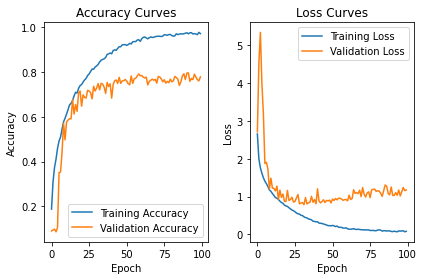

In [54]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(cnn_log.history['sparse_categorical_accuracy'])
plt.plot(cnn_log.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(cnn_log.history['loss'])
plt.plot(cnn_log.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')

plt.tight_layout()
plt.show()

In [55]:
predictions = np.argmax(cnn_model.predict(test_data), axis=-1)

In [56]:
cm = confusion_matrix(test_labels, predictions)

Confusion matrix for CNN


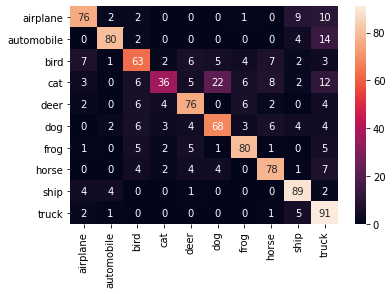

In [57]:
print("Confusion matrix for CNN")
sns.heatmap(cm, annot=True, xticklabels=class_labels, 
            yticklabels=class_labels)

In [58]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       100
           1       0.89      0.80      0.84       100
           2       0.67      0.63      0.65       100
           3       0.73      0.36      0.48       100
           4       0.75      0.76      0.76       100
           5       0.68      0.68      0.68       100
           6       0.80      0.80      0.80       100
           7       0.76      0.78      0.77       100
           8       0.77      0.89      0.82       100
           9       0.60      0.91      0.72       100

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.73      1000
weighted avg       0.74      0.74      0.73      1000

